# Probability Models

To generate profiles, we use the [Preflib.org](https://preflib.org) tools available at [https://github.com/PrefLib/PrefLib-Tools](https://github.com/PrefLib/PrefLib-Tools).   


## Impartial (Anonymous) Culture

1. IC: Impartial Culture Model - generate a profile by sampling  from a uniform distribution over profiles with $n$ candidates and $m$ voters. 

2. IAC: Impartial Anonymous Culture Model - generate a profile by sampling  from a uniform distribution over *anonymous* profiles with $n$ candidates and $m$ voters. 

3. INAC: Impartial Anonymous and Neutral Culture Model<br/>
    O. Egecioglu and A. Giritligil (2013). [The Impartial, Anonymous, and Neutral Culture Model: A Probability Model for Sampling Public Preference Structures](https://sites.cs.ucsb.edu/~omer/DOWNLOADABLE/GMAS_public_preference13.pdf), Journal of Mathematical Sociology, 37: pp. 203 - 222

In [1]:
# import the Profile class
from voting.profiles import Profile
from voting.generate_profiles import *
from voting.voting_methods import *
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import pickle
import random

from tqdm.notebook import tqdm

In [2]:
pm="IC"
num_trials = 1000
num_candidates = 5
num_voters = 1001

num_condorcet_winner = 0
num_cycles = 0
for t in range(num_trials): 
    prof = generate_profile(num_candidates, num_voters, probmod = pm)
    num_condorcet_winner += prof.condorcet_winner() is not None
    num_cycles += has_cycle(prof.margin_graph())
    
print(f"{round(num_condorcet_winner / num_trials, 2) *100}% of profiles have a Condorcet winner.")
print(f"{round(num_cycles / num_trials, 2) *100}% of profiles have a majority cycle.")

74.0% of profiles have a Condorcet winner.
49.0% of profiles have a majority cycle.


In [143]:
pm="IAC"
num_trials = 1000
num_candidates = 5
num_voters = 1001

num_condorcet_winner = 0
num_cycles = 0
for t in range(num_trials): 
    prof = generate_profile(num_candidates, num_voters, probmod = pm)
    num_condorcet_winner += prof.condorcet_winner() is not None
    num_cycles += has_cycle(prof.margin_graph())
print(f"{round(num_condorcet_winner / num_trials, 2) *100}% of profiles have a Condorcet winner.")
print(f"{round(num_cycles / num_trials, 2) * 100}% of profiles have a majority cycle.")

75.0% of profiles have a Condorcet winner.
47.0% of profiles have a majority cycle.


In [144]:
%%time 

SKIP_SIMULATION = True

if not SKIP_SIMULATION: 
    all_num_candidates = [3, 4, 5, 6, 10]
    all_num_voters = [10, 11, 100, 101, 1000, 1001]
    num_trials = 25000

    voting_scenarios = list(product(all_num_candidates, all_num_voters))
    data = {vs: 
            {
                "perc_condorcet_winners": {"IC": 0, "IAC": 0},
                "perc_cycles": {"IC": 0, "IAC": 0},            
            } 
            for vs in voting_scenarios
           }

    for nc, nv in tqdm(voting_scenarios): 
        num_condorcet_winner_IC = 0
        num_condorcet_winner_IAC = 0
        num_cycle_IC = 0
        num_cycle_IAC = 0
        for t in range(num_trials): 
            prof_IC = generate_profile(nc, nv, probmod="IC")       
            prof_IAC = generate_profile(nc, nv, probmod="IAC")        

            num_condorcet_winner_IC += prof_IC.condorcet_winner() is not None 
            num_cycle_IC += has_cycle(prof_IC.margin_graph())

            num_condorcet_winner_IAC += prof_IAC.condorcet_winner() is not None 
            num_cycle_IAC += has_cycle(prof_IAC.margin_graph())

        data[(nc, nv)]["perc_condorcet_winners"]["IC"] = num_condorcet_winner_IC /  num_trials
        data[(nc, nv)]["perc_cycles"]["IC"] = num_cycle_IC /  num_trials
        data[(nc, nv)]["perc_condorcet_winners"]["IAC"] = num_condorcet_winner_IAC /  num_trials
        data[(nc, nv)]["perc_cycles"]["IAC"] = num_cycle_IAC /  num_trials

    pickle.dump(data, open("condorcet_data.pkl", "wb"))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [145]:
import tabulate

if SKIP_SIMULATION: 
    data = pickle.load(open("condorcet_data.pkl", "rb"))
    all_num_candidates = [3, 4, 5, 6, 10]
    all_num_voters = [10, 11, 100, 101, 1000, 1001]

table = list()
headers = list()

for nc in all_num_candidates: 
    row = [nc]
    for nv in all_num_voters: 
        row.append(f"{round(data[(nc, nv)]['perc_condorcet_winners']['IC'],2)}, {round(data[(nc, nv)]['perc_condorcet_winners']['IAC'],2)}")
    table.append(row)
headers = [str(nv) for nv in all_num_voters]
print(tabulate.tabulate(table, headers, tablefmt="github"))
                   

|    | 10         | 11         | 100        | 101        | 1000       | 1001       |
|----|------------|------------|------------|------------|------------|------------|
|  3 | 0.58, 0.73 | 0.92, 0.94 | 0.79, 0.91 | 0.91, 0.94 | 0.87, 0.94 | 0.91, 0.94 |
|  4 | 0.47, 0.54 | 0.84, 0.85 | 0.69, 0.78 | 0.82, 0.84 | 0.78, 0.83 | 0.83, 0.84 |
|  5 | 0.39, 0.41 | 0.77, 0.77 | 0.61, 0.65 | 0.75, 0.75 | 0.7, 0.74  | 0.75, 0.75 |
|  6 | 0.34, 0.34 | 0.71, 0.71 | 0.54, 0.56 | 0.69, 0.68 | 0.64, 0.66 | 0.68, 0.68 |
| 10 | 0.21, 0.21 | 0.55, 0.55 | 0.39, 0.38 | 0.52, 0.52 | 0.47, 0.47 | 0.51, 0.51 |


## Urn Model

In the Polya-Eggenberger urn model, each voter in turn randomly draws a linear order from an urn. Initially the urn is $\mathcal{L}(X)$. If a voter randomly chooses $L$ from the urn, we return $L$ to the urn plus $\alpha\in\mathbb{N}$ copies of $L$. 

* IC is the special case where $\alpha=0$. 
* IAC is the special case where $\alpha=1$. 


In [146]:
print("Generated by the URN model with alpha = 0")
prof = generate_profile(4, 5, probmod="URN", probmod_param=0)
prof.display()

print("Generated by the URN model with alpha = 1")
prof = generate_profile(4, 5, probmod="URN", probmod_param=1)
prof.display()

print("Generate by URN model with alpha = 10")
prof = generate_profile(4, 5, probmod="URN", probmod_param=10)
prof.display()

print("Generate by URN model with alpha = 100")
prof = generate_profile(4, 5, probmod="URN", probmod_param=100)
prof.display()

Generated by the URN model with alpha = 0
+---+---+---+---+
| 1 | 1 | 1 | 2 |
+---+---+---+---+
| 3 | 1 | 3 | 0 |
| 2 | 3 | 1 | 2 |
| 0 | 0 | 0 | 3 |
| 1 | 2 | 2 | 1 |
+---+---+---+---+
Generated by the URN model with alpha = 1
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 0 | 1 | 2 | 2 |
| 3 | 3 | 3 | 1 | 0 |
| 1 | 1 | 0 | 3 | 1 |
| 0 | 2 | 2 | 0 | 3 |
+---+---+---+---+---+
Generate by URN model with alpha = 10
+---+---+---+
| 3 | 1 | 1 |
+---+---+---+
| 2 | 0 | 2 |
| 3 | 1 | 1 |
| 0 | 2 | 0 |
| 1 | 3 | 3 |
+---+---+---+
Generate by URN model with alpha = 100
+---+---+
| 4 | 1 |
+---+---+
| 3 | 0 |
| 0 | 3 |
| 1 | 2 |
| 2 | 1 |
+---+---+


In [147]:
## from preflib tools ###

# Generate votes based on the URN Model..
# we need numvotes with replace replacements.
def gen_urn(numvotes, replace, alts):
    voteMap = {}
    ReplaceVotes  = {}
    
    ICsize = math.factorial(len(alts))
    print("ICsize ", ICsize)
    ReplaceSize = 0

    for x in range(numvotes):
        print("initially  voteMap is", voteMap)
        print("initially ReplaceVotes is", ReplaceVotes)
        flip =  random.randint(1, ICsize+ReplaceSize)
        print("flip:", flip)
        if flip <= ICsize:
            #generate an IC vote and make a suitable number of replacements...
            print("flip less than ICsize, so generate a new ranking")
            tvote = tuple(np.random.permutation(len(alts))) # gen_ic_vote(alts)
            voteMap[tvote] = (voteMap.get(tvote, 0) + 1)
            ReplaceVotes[tvote] = (ReplaceVotes.get(tvote, 0) + replace)
            ReplaceSize += replace
            print("ReplaceSize", ReplaceSize)
            print("made " + str(tvote))
        else:
            print("find the ranking from ReplaceVote ")

            #iterate over replacement hash and select proper vote.
            flip = flip - ICsize
            for vote in ReplaceVotes.keys():
                print("testing ", vote)
                flip = flip - ReplaceVotes[vote]
                print("flip is now", flip)
                if flip <= 0:
                    print("Found the ranking")
                    voteMap[vote] = (voteMap.get(vote, 0) + 1)
                    ReplaceVotes[vote] = (ReplaceVotes.get(vote, 0) + replace)
                    ReplaceSize += replace
                    break
            else:
                print("We Have a problem... replace fell through....")		
                exit()
        print("now, voteMap is", voteMap)
        print("now, ReplaceVotes is", ReplaceVotes)
        print("======\n")
    return voteMap

# Return a TUPLE! IC vote given a vector of alternatives.   

def gen_ic_vote(alts):
    options = list(alts)
    vote  = []
    while(len(options) > 0):
        #randomly select an option
        vote.append(options.pop(random.randint(0,len(options)-1)))
    return tuple(vote)


In [148]:
gen_urn(5,1,[0,1,2,3])

ICsize  24
initially  voteMap is {}
initially ReplaceVotes is {}
flip: 7
flip less than ICsize, so generate a new ranking
ReplaceSize 1
made (3, 0, 1, 2)
now, voteMap is {(3, 0, 1, 2): 1}
now, ReplaceVotes is {(3, 0, 1, 2): 1}

initially  voteMap is {(3, 0, 1, 2): 1}
initially ReplaceVotes is {(3, 0, 1, 2): 1}
flip: 6
flip less than ICsize, so generate a new ranking
ReplaceSize 2
made (3, 1, 2, 0)
now, voteMap is {(3, 0, 1, 2): 1, (3, 1, 2, 0): 1}
now, ReplaceVotes is {(3, 0, 1, 2): 1, (3, 1, 2, 0): 1}

initially  voteMap is {(3, 0, 1, 2): 1, (3, 1, 2, 0): 1}
initially ReplaceVotes is {(3, 0, 1, 2): 1, (3, 1, 2, 0): 1}
flip: 17
flip less than ICsize, so generate a new ranking
ReplaceSize 3
made (2, 0, 3, 1)
now, voteMap is {(3, 0, 1, 2): 1, (3, 1, 2, 0): 1, (2, 0, 3, 1): 1}
now, ReplaceVotes is {(3, 0, 1, 2): 1, (3, 1, 2, 0): 1, (2, 0, 3, 1): 1}

initially  voteMap is {(3, 0, 1, 2): 1, (3, 1, 2, 0): 1, (2, 0, 3, 1): 1}
initially ReplaceVotes is {(3, 0, 1, 2): 1, (3, 1, 2, 0): 1, (2, 0,

{(3, 0, 1, 2): 1,
 (3, 1, 2, 0): 1,
 (2, 0, 3, 1): 1,
 (2, 3, 1, 0): 1,
 (1, 3, 2, 0): 1}

## Mallows Model

In the Mallow's model, given a reference ranking $L_0\in\mathcal{L}(X)$ and $\phi\in (0,1]$, the probability that a voter's ballot is $L\in\mathcal{L}(X)$ is $Pr_{L_0}(L)=\phi^{\tau(L,L_0)}/C$ where $\tau(L,L_0)= {{|X|}\choose{2}} - |L\cap L_0|$, the Kendell-tau distance of $L$ to $L_0$, and $C$ is a normalization constant.   


The **Kendal-tau** distance, also known as the **swap** distance,  between rankings $R_1$ and $R_2$ is the minimal number of swaps of adjacent candidates needed to turn vote $R_1$ into vote $R_2$.


E.g., the rankings $a\ b\ c\ d$  and $a\ d\ b\ c$ has a swap distance of 2. 

IC is the special case where $\phi=1$.  


MALLOWS_2REF: Consider an ordering $L_0$ and its converse $L_0^{-1}$ (e.g., $L_0$ ranks candidates from more liberal to more conservative, and $L_0^{-1}$ vice versa), in which case the probability that a voter's ballot is $L$ is $\frac{1}{2} Pr_{L_0}(L)+\frac{1}{2}Pr_{L_0^{-1}}(L)$. 

In [149]:
import random 

# For Phi and a given number of candidates, compute the
# insertion probability vectors.
def compute_mallows_insertvec_dist(ncand, phi):
    #Compute the Various Mallows Probability Distros
    vec_dist = {}
    for i in range(1, ncand+1):
        #Start with an empty distro of length i
        dist = [0] * i
        #compute the denom = phi^0 + phi^1 + ... phi^(i-1)
        denom = sum([pow(phi,k) for k in range(i)])
        #Fill each element of the distro with phi^i-j / denom
        for j in range(1, i+1):
            dist[j-1] = pow(phi, i - j) / denom
        #print(str(dist) + "total: " + str(sum(dist)))
        vec_dist[i] = dist
    return vec_dist

# Return a value drawn from a particular distribution.
def draw(values, distro):
    #Return a value randomly from a given discrete distribution.
    #This is a bit hacked together -- only need that the distribution
    #sums to 1.0 within 5 digits of rounding.
    if round(sum(distro),5) != 1.0:
        print("Input Distro is not a Distro...")
        print(str(distro) + "  Sum: " + str(sum(distro)))
        exit()
    if len(distro) != len(values):
        print("Values and Distro have different length")

    cv = 0
    draw = random.random() - distro[cv]
    while draw > 0.0:
        cv+= 1
        draw -= distro[cv]
    return values[cv]


In [150]:

# Generate a Mallows model with the various mixing parameters passed in
# nvoters is the number of votes we need
# candmap is a candidate map
# mix is an array such that sum(mix) == 1 and describes the distro over the models
# phis is an array len(phis) = len(mix) = len(refs) that is the phi for the particular model
# refs is an array of dicts that describe the reference ranking for the set.
def gen_mallows(nvoters, candmap, mix, phis, refs):

    if len(mix) != len(phis) or len(phis) != len(refs):
        print("Mix != Phis != Refs")
        exit()

    print("refs is", refs)
    #Precompute the distros for each Phi and Ref.
    #Turn each ref into an order for ease of use...
    m_insert_dists = []
    for i in range(len(mix)):
        m_insert_dists.append(compute_mallows_insertvec_dist(len(candmap), phis[i]))
    print("m_insert_dists", m_insert_dists)
    #Now, generate votes...
    votemap = {}
    for cvoter in range(nvoters):
        cmodel = draw(list(range(len(mix))), mix)
        print("cmodel is ", cmodel)
        #Generate a vote for the selected model
        insvec = [0] * len(candmap)
        for i in range(1, len(insvec)+1):
            #options are 1...max
            print("i is ", i)
            print("Options: " + str(list(range(1, i+1))))
            print("Drawing on model " + str(cmodel))
            print("Dist: " + str(m_insert_dists[cmodel][i]))
            print("range ", list(range(1, i+1)))
            insvec[i-1] = draw(list(range(1, i+1)), m_insert_dists[cmodel][i])
            print("choice is ", insvec[i-1]) 
            print("--\n")
        print("\ninsvec is ", insvec,"\n")
        vote = []
        for i in range(len(refs[cmodel])):
            print("i is ", i)
            print("refs is ", refs[cmodel])
            print("building vote ", refs[cmodel][i])
            #print("building vote insvec[i] - 1", insvec[i]-1)
            vote.insert(insvec[i]-1, refs[cmodel][i])
            print("vote is ", vote)
            print("++++\n")
        print("mallows vote: " + str(vote))
        tvote = tuple(vote)
        
        votemap[tuple(vote)] = votemap.get(tuple(vote), 0) + 1
        print("-------\n")
    return votemap


In [151]:
num_cands = 4
num_voters = 2
phis = [1.0]
cmap = {cn:cn for cn in range(num_cands)}
print(cmap)


print(gen_mallows(num_voters, 
                  cmap, 
                  [1.0], 
                  phis, 
                  [{0:3, 1:1, 2:0, 3:2}]))

{0: 0, 1: 1, 2: 2, 3: 3}
refs is [{0: 3, 1: 1, 2: 0, 3: 2}]
m_insert_dists [{1: [1.0], 2: [0.5, 0.5], 3: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 4: [0.25, 0.25, 0.25, 0.25]}]
cmodel is  0
i is  1
Options: [1]
Drawing on model 0
Dist: [1.0]
range  [1]
choice is  1
--

i is  2
Options: [1, 2]
Drawing on model 0
Dist: [0.5, 0.5]
range  [1, 2]
choice is  1
--

i is  3
Options: [1, 2, 3]
Drawing on model 0
Dist: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
range  [1, 2, 3]
choice is  2
--

i is  4
Options: [1, 2, 3, 4]
Drawing on model 0
Dist: [0.25, 0.25, 0.25, 0.25]
range  [1, 2, 3, 4]
choice is  4
--


insvec is  [1, 1, 2, 4] 

i is  0
refs is  {0: 3, 1: 1, 2: 0, 3: 2}
building vote  3
vote is  [3]
++++

i is  1
refs is  {0: 3, 1: 1, 2: 0, 3: 2}
building vote  1
vote is  [1, 3]
++++

i is  2
refs is  {0: 3, 1: 1, 2: 0, 3: 2}
building vote  0
vote is  [1, 0, 3]
++++

i is  3
refs is  {0: 3, 1: 1, 2: 0, 3: 2}
building vote  2
vote is  [1, 0, 3, 2]
++++

In [152]:
print("Generated by the MALLOWS model with phi = 0")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=0)
prof.display()

print("Generated by the MALLOWS model with phi = 0.1")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=0.1)
prof.display()

print("Generated by the MALLOWS model with phi = 0.5")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=0.5)
prof.display()

print("Generated by the MALLOWS model with phi = 0.8")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=0.8)
prof.display()


print("Generated by the MALLOWS model with phi = 1")
prof = generate_profile(4, 5, probmod="MALLOWS", probmod_param=1.0)
prof.display()


Generated by the MALLOWS model with phi = 0
+---+
| 5 |
+---+
| 2 |
| 3 |
| 0 |
| 1 |
+---+
Generated by the MALLOWS model with phi = 0.1
+---+---+---+
| 3 | 1 | 1 |
+---+---+---+
| 2 | 1 | 2 |
| 1 | 2 | 1 |
| 3 | 3 | 0 |
| 0 | 0 | 3 |
+---+---+---+
Generated by the MALLOWS model with phi = 0.5
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 3 | 3 | 2 | 1 |
| 1 | 1 | 1 | 3 | 3 |
| 3 | 0 | 2 | 1 | 2 |
| 0 | 2 | 0 | 0 | 0 |
+---+---+---+---+---+
Generated by the MALLOWS model with phi = 0.8
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 2 | 2 | 0 | 3 |
| 2 | 3 | 1 | 1 | 2 |
| 3 | 0 | 3 | 2 | 0 |
| 0 | 1 | 0 | 3 | 1 |
+---+---+---+---+---+
Generated by the MALLOWS model with phi = 1
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 1 | 1 | 0 | 1 |
| 3 | 2 | 2 | 2 | 0 |
| 1 | 3 | 0 | 3 | 2 |
| 2 | 0 | 3 | 1 | 3 |
+---+---+---+---+---+


## Single Peaked 



In [153]:
# Return a Tuple for a IC-Single Peaked... with alternatives in range 1....range.
def gen_icsp_single_vote(alts):
    a = 0
    b = len(alts)-1
    temp = []
    while a != b:
        print(f"a={a}, b={b}")
        if random.randint(0,1) == 1:
            temp.append(alts[a])
            a+= 1
        else:
            temp.append(alts[b])
            b -= 1
        print("temp is ", temp)
    temp.append(alts[a])
    print(temp)
    print("-----\n")
    return tuple(temp[::-1]) # reverse


def gen_single_peaked_impartial_culture_strict(nvotes, alts):
    voteset = {}
    for i in range(nvotes):
        tvote = gen_icsp_single_vote(alts)
        voteset[tvote] = voteset.get(tvote, 0) + 1
    return voteset




In [154]:
num_cands = 4
num_voters = 1

vs = gen_single_peaked_impartial_culture_strict(num_voters, list(range(num_cands)))

prof = Profile([v[0] for v in vs.items()], num_cands, rcounts = [v[1] for v in vs.items()])
prof.display()

a=0, b=3
temp is  [0]
a=1, b=3
temp is  [0, 3]
a=1, b=2
temp is  [0, 3, 2]
[0, 3, 2, 1]
-----

+---+
| 1 |
+---+
| 1 |
| 2 |
| 3 |
| 0 |
+---+


## Spatial Model 

S. Merrill, III (1993). [Voting behavior under the directional spatial model of electoral
competition](https://link.springer.com/article/10.1007/BF01047992), Public Choice 77, pp. 739 - 756.



In [155]:
def voter_utility(v_pos, c_pos, beta):
    '''Based on the Rabinowitz and Macdonald (1989) mixed model
    described in Section 3, pp. 745 - 747 of 
    "Voting behavior under the directional spatial model of electoral competition" by S. Merrill III 
    
    beta = 1 is the proximity model
    beta = 0 is the directional model
    '''
    return 2 * np.dot(v_pos, c_pos) - beta*(np.linalg.norm(v_pos)**2 + np.linalg.norm(c_pos)**2)

def create_prof_spatial_model2(num_voters, cmap, params):
    num_dim = params[0] # the first component of the parameter is the number of dimensions
    beta = params[1] # used to define the mixed model: beta = 1 is proximity model (i.e., Euclidean distance)
    num_cands = len(cmap.keys())  
    mean = [0] * num_dim # mean is 0 for each dimension
    cov = np.diag([1]*num_dim)  # diagonal covariance
    
    # sample candidate/voter positions using a multivariate normal distribution
    cand_positions = np.random.multivariate_normal(np.array(mean), cov, num_cands)
    voter_positions = np.random.multivariate_normal(np.array(mean), cov, num_voters)
    
    # generate the rankings and counts for each ranking
    ranking_counts = dict()
    for v,v_pos in enumerate(voter_positions):
        v_utils = {voter_utility(v_pos,c_pos,beta): c for c,c_pos in enumerate(cand_positions)}
        ranking = tuple([v_utils[_u] for _u in sorted(v_utils.keys(),reverse=True)])
        if ranking in ranking_counts.keys():
            ranking_counts[ranking] += 1
        else:
            ranking_counts.update({ranking:1})
    
    # list of tuples where first component is a ranking and the second is the count
    prof_counts = ranking_counts.items()
    
    return [rc[0] for rc in prof_counts], [rc[1] for rc in prof_counts], list(voter_positions), list(cand_positions)


+---+---+---+---+---+---+
| 2 | 2 | 3 | 1 | 1 | 1 |
+---+---+---+---+---+---+
| 0 | 3 | 0 | 1 | 1 | 2 |
| 2 | 0 | 3 | 2 | 3 | 1 |
| 3 | 2 | 2 | 3 | 2 | 0 |
| 1 | 1 | 1 | 0 | 0 | 3 |
+---+---+---+---+---+---+
the utility of 0 is -0.024393994065882052
the utility of 1 is -2.6965831449803153
the utility of 2 is -1.0185317882425324
the utility of 3 is -1.4662475766935383


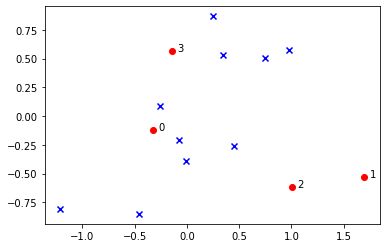

In [173]:
num_cands = 4

beta = 0.5
dim = 2

rankings,rcounts,voter_positions, cand_positions = create_prof_spatial_model2(10, 
                                                                              {c:c for c in range(num_cands)}, 
                                                                              [dim, beta])
prof = Profile(rankings, num_cands, rcounts=rcounts)

prof.display()

plt.scatter([v[0] for v in voter_positions], [v[1] for v in voter_positions], color='blue', marker='x')

plt.scatter([c[0] for c in cand_positions], [c[1] for c in cand_positions], color='red', marker='o')

for c_idx,c in enumerate(cand_positions):
    print(f"the utility of {c_idx} is {voter_utility(voter_positions[0], c, beta)}")

for c_idx,c in enumerate(cand_positions):
    plt.text(c[0]+0.05, c[1], c_idx)
plt.show()

+---+---+---+---+
| 5 | 3 | 1 | 1 |
+---+---+---+---+
| 0 | 2 | 1 | 2 |
| 2 | 0 | 2 | 1 |
| 1 | 1 | 3 | 0 |
| 3 | 3 | 0 | 3 |
+---+---+---+---+
the utility of 0 is -0.0344799207897591
the utility of 1 is -1.5538322304333583
the utility of 2 is -0.09778957469225838
the utility of 3 is -2.513540349854728


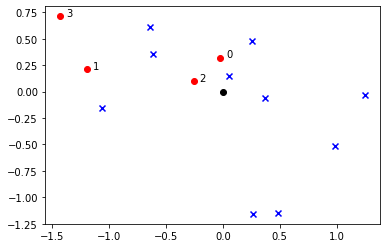

In [174]:
num_cands = 4
beta = 1.0
dim = 2


rankings,rcounts,voter_positions, cand_positions = create_prof_spatial_model2(10, 
                                                                              {c:c for c in range(num_cands)}, 
                                                                              [dim, beta])


prof = Profile(rankings, num_cands, rcounts=rcounts)

prof.display()


plt.scatter([v[0] for v in voter_positions], [v[1] for v in voter_positions], color='blue', marker='x')

plt.scatter([c[0] for c in cand_positions], [c[1] for c in cand_positions], color='red', marker='o')

plt.scatter([0], [0], color='black', marker='o')

for c_idx,c in enumerate(cand_positions):
    print(f"the utility of {c_idx} is {voter_utility(voter_positions[0], c, beta)}")

    
for c_idx,c in enumerate(cand_positions):
    plt.text(c[0]+0.05, c[1], c_idx)
plt.show()

In [175]:
num_voters = 10
num_cands = 4

e_model = "1d_interval"
#1d_interval
#1d_interval_bis"
#1d_gaussian
#1d_gaussian_bis
#1d_one_sided_triangle
#1d_full_triangle
#1d_two_party 

from mapel.voting import elections

rankings = elections.generate_elections_1d_simple(election_model = e_model, 
                                                  num_voters=num_voters, 
                                                  num_candidates = num_cands)

prof = Profile([tuple(r) for r in rankings], num_cands)
prof.display()


+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 2 | 2 | 2 | 3 |
| 0 | 0 | 0 | 0 | 0 | 0 | 3 | 3 | 3 | 2 |
| 2 | 2 | 2 | 2 | 2 | 2 | 1 | 1 | 1 | 1 |
| 3 | 3 | 3 | 3 | 3 | 3 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+---+---+---+


In [100]:
num_voters = 10
num_cands = 4

e_model = "2d_disc"

#2d_disc
#2d_range_disc
#2d_range_overlapping
#2d_square 
#2d_sphere
#2d_gaussian
#2d_range_gaussian 
#2d_range_fourgau 

        
rankings = elections.generate_elections_2d_simple(election_model = e_model, 
                                                  num_voters=num_voters, 
                                                  num_candidates = num_cands)

prof = Profile([tuple(r) for r in rankings], num_cands)
prof.display()


+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+
| 1 | 0 | 1 | 2 | 1 | 2 | 2 | 2 | 3 | 3 |
| 0 | 1 | 2 | 0 | 2 | 0 | 0 | 0 | 2 | 2 |
| 2 | 2 | 0 | 1 | 0 | 1 | 1 | 1 | 1 | 1 |
| 3 | 3 | 3 | 3 | 3 | 3 | 3 | 3 | 0 | 0 |
+---+---+---+---+---+---+---+---+---+---+


In [176]:
num_voters = 10
num_cands = 4


e_model = "40d_ball"

# 3d_sphere
# 3d_cube
# 3d_ball
# 4d_sphere
# 4d_cube
# 4d_ball
# 5d_sphere
# 5d_cube
# 5d_ball
# 10d_cube
# 15d_cube
# 20d_cube
# 40d_cube
# 40d_ball
   
rankings = elections.generate_elections_nd_simple(election_model = e_model, 
                                                  num_voters=num_voters, 
                                                  num_candidates = num_cands)

prof = Profile([tuple(r) for r in rankings], num_cands)
prof.display()


+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+
| 3 | 1 | 2 | 0 | 0 | 2 | 2 | 2 | 2 | 0 |
| 0 | 2 | 0 | 2 | 3 | 1 | 1 | 3 | 1 | 3 |
| 2 | 0 | 1 | 1 | 2 | 0 | 0 | 0 | 0 | 2 |
| 1 | 3 | 3 | 3 | 1 | 3 | 3 | 1 | 3 | 1 |
+---+---+---+---+---+---+---+---+---+---+


## Mapping Elections



S. Szufa, P. Piotr Faliszewski, P. Skowron, A. Skinko,  and N. Talmon, [Drawing a Map of Elections in the Space of Statistical Cultures](http://www.ifaamas.org/Proceedings/aamas2020/pdfs/p1341.pdf), AAMAS 2020, Auckland, New Zealand, 


In [102]:
import mapel
import math
mapel.hello()

print()

#mapel.compute_highest_borda("testbed_100_100") 


Hello!



/Users/epacuit/Dropbox/teaching/ppe-simulation/notes/preference-aggregation/experiments/testbed_100_100/controllers/points/positionwise_2d_a1.csv


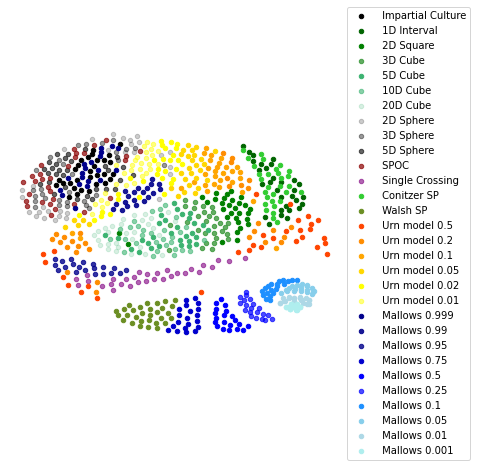

In [127]:
mapel.print_2d("testbed_100_100")

/Users/epacuit/Dropbox/teaching/ppe-simulation/notes/preference-aggregation/experiments/testbed_100_100/controllers/points/positionwise_2d_a1.csv


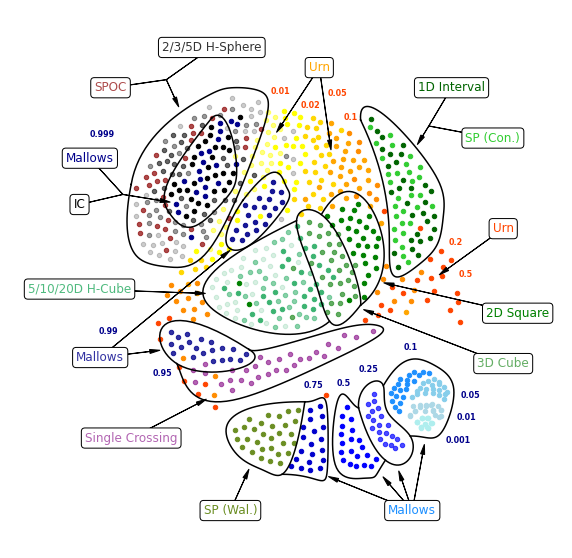

In [128]:
mapel.print_2d("testbed_100_100", mask=True)

In [129]:
import os
from mapel.voting import objects as obj

def get_highest_borda_score(election):
    scores = [0 for _ in range(election.num_candidates)]
    for vote in election.votes:
        print(vote)
        for i in range(len(vote)):
            scores[vote[i]] += election.num_candidates - i - 1
    return max(scores)


def is_condorect_winner(election):

    for i in range(election.num_candidates):

        condocret_winner = True
        for j in range(election.num_candidates):

            diff = 0
            for k in range(election.num_voters):

                if election.potes[k][i] <= election.potes[k][j]:
                    diff += 1

            if diff < math.ceil((election.num_voters+1)/2.):
                condocret_winner = False
                break

        if condocret_winner:
            return True

    return False


def compute_highest_borda(experiment_id):

    model = obj.Model(experiment_id)
    for i in range(model.num_elections)[0:10]:
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        score = get_highest_borda_score(election)
        print(i, score)

        file_name = 'borda_score.txt'
        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

def compute_condorcet_winner(experiment_id):

    model = obj.Model(experiment_id)
    file_name = 'condorcet_score.txt'
    path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
    os.remove(path)
    for i in range(model.num_elections):
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        score = float(int(is_condorect_winner(election)))
        print(i, score)

        file_name = 'condorcet_score.txt'
        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

compute_condorcet_winner('testbed_100_100')

0 0.0
1 1.0
2 1.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 1.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 1.0
34 0.0
35 0.0
36 0.0
37 0.0
38 1.0
39 0.0
40 1.0
41 1.0
42 1.0
43 1.0
44 0.0
45 1.0
46 0.0
47 1.0
48 1.0
49 0.0
50 1.0
51 0.0
52 1.0
53 0.0
54 1.0
55 0.0
56 0.0
57 1.0
58 1.0
59 0.0
60 1.0
61 1.0
62 0.0
63 0.0
64 0.0
65 1.0
66 1.0
67 1.0
68 1.0
69 1.0
70 1.0
71 1.0
72 1.0
73 1.0
74 0.0
75 0.0
76 1.0
77 0.0
78 0.0
79 1.0
80 1.0
81 1.0
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0
89 1.0
90 1.0
91 1.0
92 1.0
93 1.0
94 1.0
95 1.0
96 1.0
97 1.0
98 1.0
99 1.0
100 1.0
101 1.0
102 0.0
103 1.0
104 1.0
105 1.0
106 0.0
107 0.0
108 1.0
109 1.0
110 0.0
111 1.0
112 1.0
113 1.0
114 1.0
115 1.0
116 1.0
117 1.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0
124 1.0
125 1.0
126 1.0
127 1.0
128 1.0
129 1.0
130 1.0
131 1.0
132 1.0
133 1.0
134 1.0
135 1.0
136 0.0
137 1.0
138 1.

/Users/epacuit/Dropbox/teaching/ppe-simulation/notes/preference-aggregation/experiments/testbed_100_100/controllers/points/positionwise_2d_a1.csv


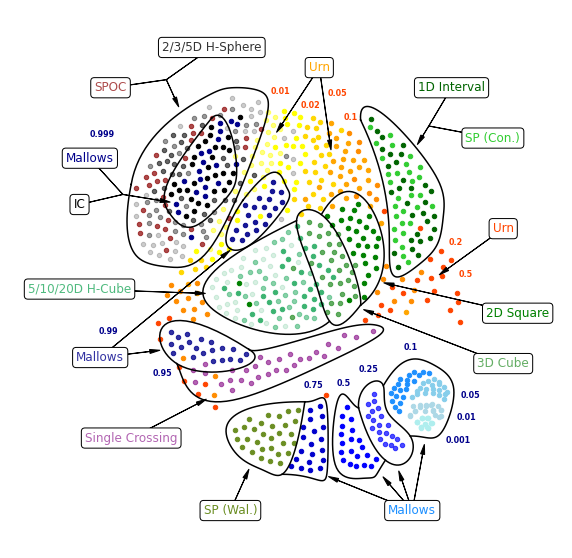

In [130]:
mapel.print_2d("testbed_100_100", mask=True)

/Users/epacuit/Dropbox/teaching/ppe-simulation/notes/preference-aggregation/experiments/testbed_100_100/controllers/points/positionwise_2d_a1.csv
0.0 1.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mapel/voting/print.py:148: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_xticklabels(xticklabels)


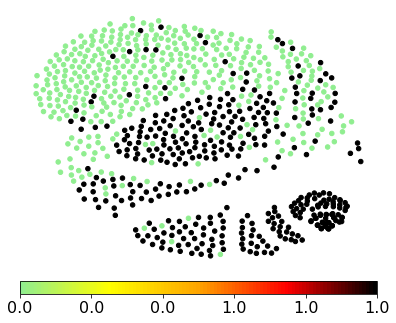

In [131]:
file_name = 'condorcet_score'
mapel.print_2d('testbed_100_100', values=file_name)


In [132]:
vms = [borda, hare, coombs, plurality_with_runoff, minimax]

def compute_diff_winners(experiment_id):

    file_name = 'diffvms_score.txt'
    path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
    os.remove(path)
    model = obj.Model(experiment_id)
    for i in range(model.num_elections):
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        #print(election.votes)
        prof = Profile([tuple(r) for r in election.votes], election.num_candidates)
        num_diff = 0
        for vm in vms: 
            if plurality(prof) != vm(prof): 
                num_diff += 1
        score = float(num_diff) 
        print(i, score)

        file_name = 'diffvms_score.txt'
        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

compute_diff_winners('testbed_100_100')



0 5.0
1 5.0
2 5.0
3 4.0
4 3.0
5 5.0
6 3.0
7 5.0
8 5.0
9 4.0
10 4.0
11 5.0
12 5.0
13 5.0
14 5.0
15 5.0
16 5.0
17 5.0
18 5.0
19 5.0
20 5.0
21 5.0
22 5.0
23 5.0
24 5.0
25 5.0
26 5.0
27 4.0
28 5.0
29 5.0
30 5.0
31 5.0
32 4.0
33 5.0
34 5.0
35 5.0
36 5.0
37 5.0
38 5.0
39 5.0
40 5.0
41 5.0
42 5.0
43 2.0
44 5.0
45 5.0
46 5.0
47 5.0
48 4.0
49 5.0
50 5.0
51 5.0
52 5.0
53 4.0
54 5.0
55 5.0
56 5.0
57 5.0
58 5.0
59 5.0
60 5.0
61 4.0
62 5.0
63 5.0
64 5.0
65 3.0
66 3.0
67 5.0
68 5.0
69 5.0
70 5.0
71 4.0
72 4.0
73 5.0
74 5.0
75 5.0
76 5.0
77 5.0
78 5.0
79 4.0
80 5.0
81 5.0
82 5.0
83 5.0
84 5.0
85 4.0
86 5.0
87 5.0
88 5.0
89 5.0
90 5.0
91 5.0
92 4.0
93 5.0
94 5.0
95 5.0
96 5.0
97 5.0
98 4.0
99 4.0
100 5.0
101 4.0
102 5.0
103 3.0
104 5.0
105 4.0
106 4.0
107 5.0
108 5.0
109 5.0
110 5.0
111 5.0
112 5.0
113 5.0
114 5.0
115 3.0
116 3.0
117 5.0
118 5.0
119 4.0
120 3.0
121 5.0
122 5.0
123 4.0
124 4.0
125 5.0
126 4.0
127 5.0
128 5.0
129 5.0
130 5.0
131 5.0
132 5.0
133 4.0
134 5.0
135 5.0
136 5.0
137 4.0
138 5.

/Users/epacuit/Dropbox/teaching/ppe-simulation/notes/preference-aggregation/experiments/testbed_100_100/controllers/points/positionwise_2d_a1.csv
0.0 5.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mapel/voting/print.py:148: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_xticklabels(xticklabels)


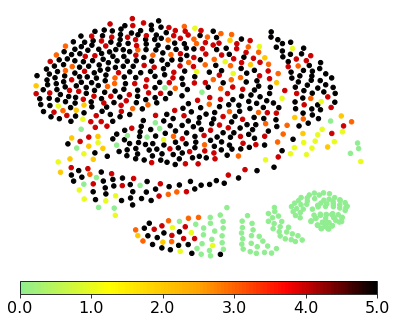

In [133]:
file_name = 'diffvms_score'
mapel.print_2d('testbed_100_100', values=file_name)


In [134]:

vm = plurality 
def compute_condorcet_eff(experiment_id):

    model = obj.Model(experiment_id)
    file_name = 'condorceteff_score.txt'
    path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
    os.remove(path)

    for i in range(model.num_elections):
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        #print(election.votes)
        prof = Profile([tuple(r) for r in election.votes], election.num_candidates)
        cw = prof.condorcet_winner()
        _score = cw is None or [cw] == vm(prof)
        score = float(_score) 
        print(i, score)

        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

compute_condorcet_eff('testbed_100_100')


0 1.0
1 0.0
2 0.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 0.0
17 1.0
18 1.0
19 1.0
20 1.0
21 1.0
22 1.0
23 1.0
24 1.0
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0
30 1.0
31 1.0
32 1.0
33 0.0
34 1.0
35 1.0
36 1.0
37 1.0
38 0.0
39 1.0
40 0.0
41 0.0
42 0.0
43 1.0
44 1.0
45 0.0
46 1.0
47 0.0
48 0.0
49 1.0
50 0.0
51 1.0
52 0.0
53 1.0
54 0.0
55 1.0
56 1.0
57 0.0
58 0.0
59 1.0
60 0.0
61 0.0
62 1.0
63 1.0
64 1.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 1.0
75 1.0
76 0.0
77 1.0
78 1.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 1.0
103 0.0
104 0.0
105 0.0
106 1.0
107 1.0
108 0.0
109 0.0
110 1.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 1.0
137 0.0
138 0.

/Users/epacuit/Dropbox/teaching/ppe-simulation/notes/preference-aggregation/experiments/testbed_100_100/controllers/points/positionwise_2d_a1.csv
0.0 1.0


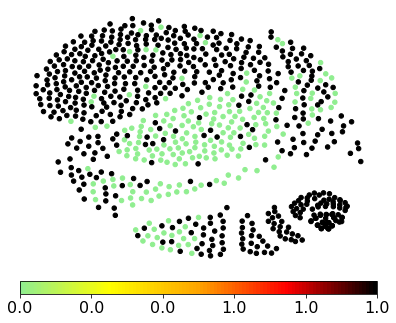

In [135]:
file_name = 'condorceteff_score'
mapel.print_2d('testbed_100_100', values=file_name, normalizing_func = lambda x: x)


In [177]:
vm = hare 
def compute_size_ws(experiment_id):

    model = obj.Model(experiment_id)
    file_name = 'size_winning_set_score.txt'
    path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
    os.remove(path)

    for i in range(model.num_elections):
        election_id = 'core_' + str(i)
        election = obj.Election(experiment_id, election_id)
        #print(election.votes)
        prof = Profile([tuple(r) for r in election.votes], election.num_candidates)
        cw = prof.condorcet_winner()
        score = float(len(vm(prof))) 
        print(i, score)

        path = os.path.join(os.getcwd(), 'experiments', experiment_id, 'controllers', 'advanced', file_name)
        with open(path, 'a') as txtfile:
            txtfile.write(str(score) + "\n")

compute_size_ws('testbed_100_100')


0 1.0
1 1.0
2 1.0
3 1.0
4 2.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 1.0
21 1.0
22 1.0
23 1.0
24 2.0
25 1.0
26 1.0
27 1.0
28 1.0
29 1.0
30 1.0
31 1.0
32 1.0
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 1.0
41 1.0
42 1.0
43 1.0
44 1.0
45 1.0
46 1.0
47 1.0
48 1.0
49 1.0
50 1.0
51 1.0
52 1.0
53 2.0
54 1.0
55 1.0
56 1.0
57 1.0
58 1.0
59 1.0
60 1.0
61 1.0
62 1.0
63 1.0
64 1.0
65 1.0
66 1.0
67 1.0
68 1.0
69 1.0
70 1.0
71 1.0
72 1.0
73 1.0
74 1.0
75 1.0
76 1.0
77 1.0
78 2.0
79 1.0
80 1.0
81 1.0
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0
89 1.0
90 1.0
91 1.0
92 1.0
93 1.0
94 1.0
95 1.0
96 1.0
97 1.0
98 1.0
99 1.0
100 1.0
101 1.0
102 1.0
103 1.0
104 1.0
105 1.0
106 1.0
107 1.0
108 1.0
109 1.0
110 1.0
111 1.0
112 1.0
113 1.0
114 1.0
115 1.0
116 1.0
117 1.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0
124 1.0
125 1.0
126 1.0
127 2.0
128 1.0
129 1.0
130 1.0
131 1.0
132 1.0
133 1.0
134 1.0
135 1.0
136 1.0
137 1.0
138 1.

/Users/epacuit/Dropbox/teaching/ppe-simulation/notes/preference-aggregation/experiments/testbed_100_100/controllers/points/positionwise_2d_a1.csv
1.0 4.0


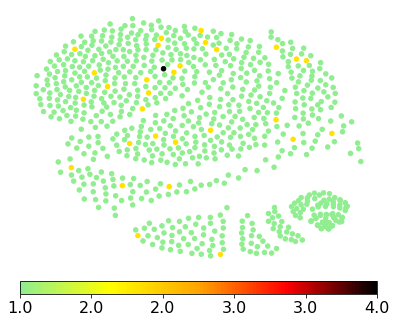

In [178]:
file_name = 'size_winning_set_score'
mapel.print_2d('testbed_100_100', values=file_name)


## Real Elections

In [138]:
import glob
election_data_directory = './election-data/'


In [139]:
# read the file containing election data and return a profile
def read_election_data(fname):
    with open(fname, 'r') as fp:
        line = fp.readline()
        num_cands = int(line)
        remaining_lines = fp.readlines()
        num_rankings = remaining_lines[num_cands]
        rankings_data = remaining_lines[num_cands + 1:]
        anon_prof = {}
        rankings = list()
        rcounts = list()
        for r in rankings_data:
            _ranking = r.split(',')
            num = int(_ranking[0])
            rankings.append(tuple([int(_.strip()) - 1 for _ in _ranking[1:num_cands+1]]))
            rcounts.append(num)
        
        return Profile(rankings,  num_cands, rcounts = rcounts)



prof = read_election_data(f"{election_data_directory}ED-00025-00000002.soc")

prof.display()

prof.condorcet_winner()

+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+
| 200 | 86 | 69 | 45 | 42 | 35 | 34 | 28 | 27 | 22 | 20 | 19 | 19 | 18 | 18 | 17 | 17 | 16 | 15 | 14 | 12 | 10 | 6 | 6 |
+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+
|  0  | 0  | 0  | 1  | 0  | 1  | 1  | 0  | 0  | 2  | 1  | 1  | 3  | 2  | 1  | 2  | 3  | 2  | 3  | 2  | 3  | 2  | 3 | 3 |
|  1  | 1  | 2  | 0  | 3  | 2  | 0  | 3  | 2  | 0  | 3  | 3  | 0  | 3  | 2  | 1  | 1  | 1  | 0  | 0  | 1  | 3  | 2 | 2 |
|  2  | 3  | 1  | 2  | 1  | 0  | 3  | 2  | 3  | 1  | 0  | 2  | 1  | 0  | 3  | 0  | 2  | 3  | 2  | 3  | 0  | 1  | 1 | 0 |
|  3  | 2  | 3  | 3  | 2  | 3  | 2  | 1  | 1  | 3  | 2  | 0  | 2  | 1  | 0  | 3  | 0  | 0  | 1  | 1  | 2  | 0  | 0 | 1 |
+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+---+


0

In [140]:
num_elections = 0
num_condorcet_winner = 0
num_cycle = 0
for fname in glob.glob(election_data_directory + "/*.soc"):
    num_elections += 1
    prof = read_election_data(fname)
    print(f"Election {num_elections}")
    print("\tNumber of candidates: ", prof.num_cands)
    print("\tNumber of voters: ", prof.num_voters)
    
    num_condorcet_winner += prof.condorcet_winner() is not None
    num_cycle += has_cycle(prof.margin_graph())
    
print(f"Out of {num_elections} elections:")
print(f"\t{round(num_condorcet_winner / num_elections, 4)*100}% have a Condorcet winner")
print(f"\t{round(num_cycle / num_elections, 4)*100}% have a cycle in the majority graph")

Election 1
	Number of candidates:  30
	Number of voters:  7
Election 2
	Number of candidates:  4
	Number of voters:  362
Election 3
	Number of candidates:  4
	Number of voters:  1256
Election 4
	Number of candidates:  4
	Number of voters:  369
Election 5
	Number of candidates:  32
	Number of voters:  4
Election 6
	Number of candidates:  60
	Number of voters:  4
Election 7
	Number of candidates:  131
	Number of voters:  4
Election 8
	Number of candidates:  3
	Number of voters:  405
Election 9
	Number of candidates:  3
	Number of voters:  779
Election 10
	Number of candidates:  3
	Number of voters:  1377
Election 11
	Number of candidates:  3
	Number of voters:  496
Election 12
	Number of candidates:  3
	Number of voters:  963
Election 13
	Number of candidates:  3
	Number of voters:  440
Election 14
	Number of candidates:  70
	Number of voters:  4
Election 15
	Number of candidates:  52
	Number of voters:  4
Election 16
	Number of candidates:  81
	Number of voters:  4
Election 17
	Number o

Election 134
	Number of candidates:  153
	Number of voters:  4
Election 135
	Number of candidates:  82
	Number of voters:  4
Election 136
	Number of candidates:  3
	Number of voters:  1860
Election 137
	Number of candidates:  3
	Number of voters:  617
Election 138
	Number of candidates:  3
	Number of voters:  529
Election 139
	Number of candidates:  3
	Number of voters:  940
Election 140
	Number of candidates:  95
	Number of voters:  4
Election 141
	Number of candidates:  128
	Number of voters:  4
Election 142
	Number of candidates:  4
	Number of voters:  448
Election 143
	Number of candidates:  4
	Number of voters:  446
Election 144
	Number of candidates:  18
	Number of voters:  7
Election 145
	Number of candidates:  4
	Number of voters:  525
Election 146
	Number of candidates:  18
	Number of voters:  9
Election 147
	Number of candidates:  4
	Number of voters:  418
Election 148
	Number of candidates:  4
	Number of voters:  392
Election 149
	Number of candidates:  14
	Number of voters:

Election 297
	Number of candidates:  67
	Number of voters:  4
Election 298
	Number of candidates:  43
	Number of voters:  4
Election 299
	Number of candidates:  21
	Number of voters:  4
Election 300
	Number of candidates:  3
	Number of voters:  426
Election 301
	Number of candidates:  3
	Number of voters:  1631
Election 302
	Number of candidates:  3
	Number of voters:  443
Election 303
	Number of candidates:  3
	Number of voters:  578
Election 304
	Number of candidates:  3
	Number of voters:  453
Election 305
	Number of candidates:  3
	Number of voters:  391
Election 306
	Number of candidates:  3
	Number of voters:  417
Election 307
	Number of candidates:  3
	Number of voters:  955
Election 308
	Number of candidates:  3
	Number of voters:  2415
Election 309
	Number of candidates:  3
	Number of voters:  554
Election 310
	Number of candidates:  55
	Number of voters:  4
Election 311
	Number of candidates:  40
	Number of voters:  4
Election 312
	Number of candidates:  17
	Number of voters: